In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

# Read Captions File

In [9]:
# Reading the Description file

with open("./flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()

In [10]:
# captions

In [11]:
captions = captions.split("\n")[:-1]

In [12]:
len(captions)

40460

In [19]:
i_to_c = captions[0].split('\t')
print(i_to_c[0].split(".")[0])
print(i_to_c[1])

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [20]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [23]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [24]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 2 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [27]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [28]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [29]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [30]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [36]:
#  reading description file

# f = open("storage/descriptions.txt", 'r')
# descriptions = f.read()
# f.close()

# json_acceptable_string = descriptions.replace("'", "\"")
# descriptions = json.loads(json_acceptable_string)

In [35]:
# creating the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [38]:
#  ALL words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [59]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [64]:
print(all_vocab[:15])

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman']


In [62]:
len(all_vocab)

1845

# Loading Training Testing Data

In [65]:
# TrainImagesFile
f = open("flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [73]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [75]:
len(train)

6000

In [76]:
# TestImagesFile
f = open("flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [77]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [78]:
len(test)

1000

In [84]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [86]:
train_descriptions['1007320043_627395c3d8']

['startseq child playing on rope net endseq',
 'startseq little girl climbing on red roping endseq',
 'startseq little girl in pink climbs rope bridge at the park endseq',
 'startseq small child grips onto the red ropes at the playground endseq',
 'startseq the small child climbs on red ropes on playground endseq']

In [88]:
# train_descriptions

# Data Preprocessing - Images

In [ ]:
"""
In this section, we will load our images and do some processing so that we can feed it in our network.
"""

In [89]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102973440/102967424 [==============================] - 47s 0us/step


In [90]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_bloc

In [91]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [94]:
images = "./flicker8k-dataset/Flickr8k_Dataset/"

In [95]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [96]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [259]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [260]:
# Save the bottleneck train features to disk

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [253]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Time taken in seconds = 303.322877407074


In [258]:
# Save the bottleneck train features to disk

with open("./storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [98]:
# Load the train images features from disk

with open("./storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [99]:
# Load the test images features from disk

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

# Data Preprocessing - Captions

In [105]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [107]:
len(word_to_idx)

1845

In [108]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [109]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [110]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [54]:
with open("./storage/word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("./storage/idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

# Data Preparation using Generator Function

In [111]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield  ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n=0

# Word Embedding

In [112]:
f = open("./GloVE/glove.6B.50d.txt", encoding='utf8')

In [113]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

## Converting words into vectors  Directly - (Embedding Layer Output)

In [120]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [121]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [135]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [137]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [138]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [139]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [140]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [141]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train Our Model

In [37]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [38]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 189s 95ms/step - loss: 4.2791
Epoch 1/1
2000/2000 [==============================] - 180s 90ms/step - loss: 3.5671
Epoch 1/1
2000/2000 [==============================] - 191s 95ms/step - loss: 3.3153
Epoch 1/1
2000/2000 [==============================] - 191s 96ms/step - loss: 3.1609
Epoch 1/1
2000/2000 [==============================] - 186s 93ms/step - loss: 3.0468
Epoch 1/1
2000/2000 [==============================] - 184s 92ms/step - loss: 2.9644
Epoch 1/1
2000/2000 [==============================] - 186s 93ms/step - loss: 2.8949
Epoch 1/1
2000/2000 [==============================] - 185s 93ms/step - loss: 2.8408
Epoch 1/1
2000/2000 [==============================] - 195s 97ms/step - loss: 2.7902
Epoch 1/1
2000/2000 [==============================] - 182s 91ms/step - loss: 2.7536


In [142]:
model = load_model("./model_weights/model_9.h5")

# Predictions

In [147]:
def predict_caption(photo):
    """
    photo : 2048 dimn vector, image encoding
    """
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

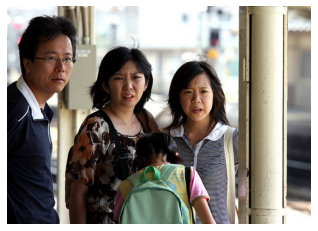

group of people are standing in front of crowd


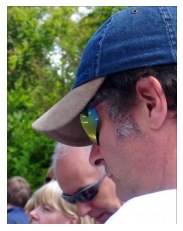

man with facial and beard and sunglasses is looking at the camera


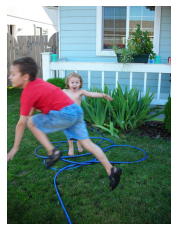

boy in red shirt and blue shorts is jumping on trampoline


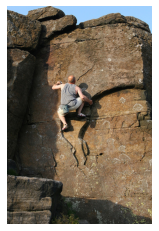

man climbing rock wall


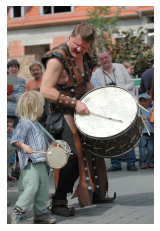

man in red shirt and black leather stands in front of red building


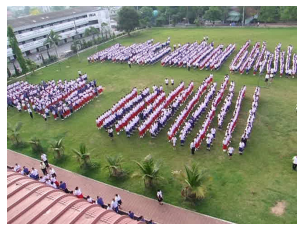

group of people are riding horses on the grass


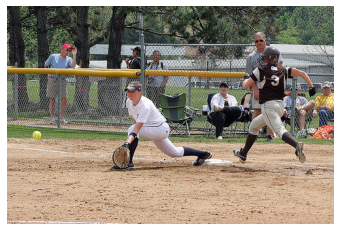

pitcher player in the air while another pitcher in blue and white uniform


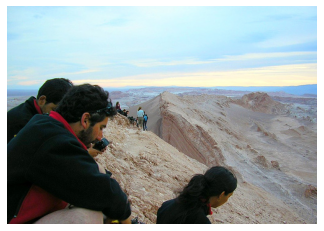

man sits on top of rocky mountain


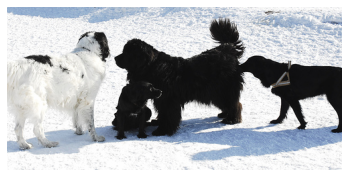

two dogs are playing with each other


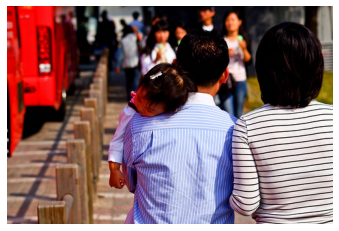

woman in red shirt is standing in front of crowd


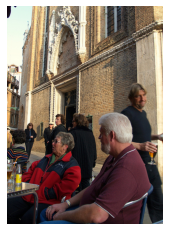

group of people are standing in front of building


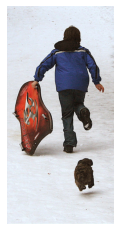

man in red coat is holding ice


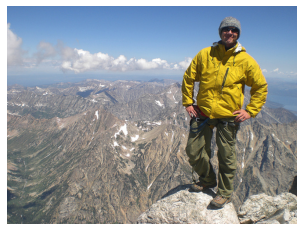

man in hat and black shirt is standing on top of mountain


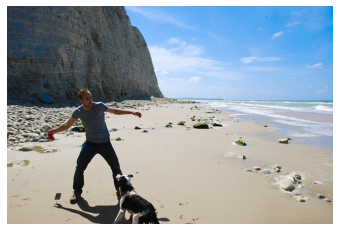

man in blue shirt is standing on the beach


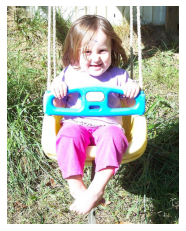

little girl in green shirt and blue shirt is smiling


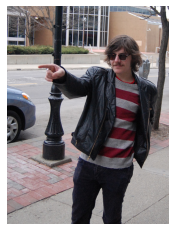

man in blue shirt and jeans is standing in front of some store


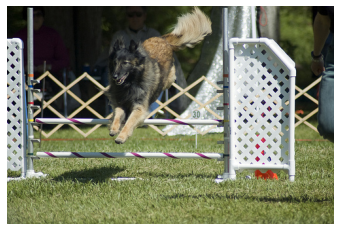

black and white dog is jumping over hurdle


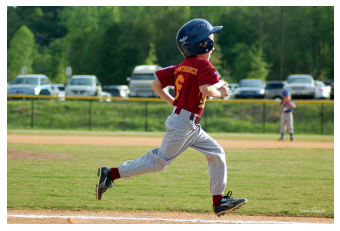

baseball player in blue uniform and blue uniform is pitching baseball


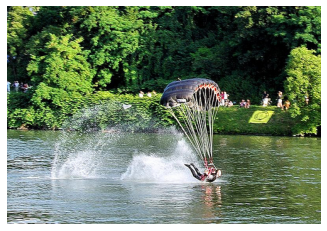

man in yellow shirt and black shorts is wakeboarding in the water


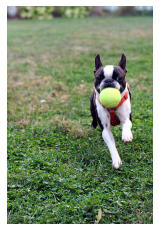

dog runs through the grass


In [166]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)